In [2]:
from openTSNE import TSNE
import numpy as np
import numpy as np
import scipy.spatial.distance as dist
import pickle
from matplotlib import pyplot as plt

In [3]:
def determine_sigma(x_dist, k_nb, local=True):
    """ Choose the width of the Gaussian kernels.
        Automatically choose the width of the Gaussian kernels based
        on the distance to the k-th nearest neighbor.
        Args:
            x_dist: matrix (nparray) of pairwise distances between
                training data points
            k_nb: number of the considered neighbor
            local: optional argument for switching between locally
                different kernels (True) and a single, average
                kernel width (False)
        Returns:
            An nparray of kernel widths if local=True, otherwise a
            scalar with the average kernel width
    """

    n = x_dist.shape[0]

    # sort distance matrix column-wise
    dist_sorted = np.sort(x_dist, axis=0)

    # disregard entries with distance 0
    ind_nb = np.sum(dist_sorted == 0, axis=0) + k_nb
    # convert to matrix indices
    ind_nb += np.arange(n) * n
    ind_nb = np.unravel_index(ind_nb-1, dist_sorted.shape, order='F')

    if local:
        return dist_sorted[ind_nb]
    else:
        return np.mean(dist_sorted[ind_nb])


def kmap_train(x_dist, y, sig, k_nb=10, local=True):
    """ Train the parameters of the kernel mapping.
        Train the parameters of the kernel mapping based on the
        distances and projections of the training data.
        Args:
            x_dist: matrix (nparray) of pairwise distances between
                training data points
            y: low-dimensional projections of the training data
            sig: scales the width of the gaussians
            k_nb: number of considered neighbor
            local: locality switch (see 'determine_sigma')
        Returns:
            A dictionary with the following entries:
                sigmas: widths of the Gaussians
                coeffs: learned mapping matrix
    """

    # compute the widths
    sig_nb = determine_sigma(x_dist, k_nb, local=local)
    sig_nb = sig_nb ** 2

    # scale the widths
    par = dict()
    par['sigmas'] = sig * sig_nb

    # compute the kernel
    ker = np.exp(- (x_dist/par['sigmas']))
    # normalise
    ker = ker / np.sum(ker, axis=1)

    # compute inverse
    par['coeffs'] = np.dot(np.linalg.pinv(ker), y)

    return par


def kmap_test(x_dist_ose, par):
    """ Map new data using learned parameters.
    Map new data to a low-dimensional space based on the
    parameters learned on the training data.
    Args:
        x_dist_ose: matrix (nparray) of pairwise distances between
            test data points and training data points
        par: parameter dictionary of the kernel mapping
            (output of 'kmap_train')
    Returns:
        An nparray with low-dimensional projections of the test data
    """

    # compute kernel
    ker_ose = np.exp(- (x_dist_ose / par['sigmas']))
    ker_ose = ker_ose / np.sum(ker_ose, axis=1, keepdims=True)

    # compute projections
    y_ose = np.dot(ker_ose, par['coeffs'])
    y_nan = np.sum(np.isnan(np.sum(y_ose, axis=1)))

    if y_nan > 0:
        print('Number of NaN elements is {}'.format(y_nan))
        print('Consider using larger sigma for training.')

    return y_ose


class KernelMap:
    """ Kernel mapping for out-of-sample extension.
    Calculate and apply a kernel mapping based on previously
    projected data (e.g. by t-SNE).
    Attributes:
        k_nb: number of considered neighbor
        local: a boolean indicating if gaussian width should
            be estimated locally (True) or globally (False)
        sig_scale: scaling factor for gaussians
        metric: function used for computing pairwise distances
        trained: a boolean indicating of kernel mapping has
            already been trained
        params: a dictionary containing the fitted parameters:
            sigmas: widths of the Gaussians
            coeffs: learned mapping matrix
        x_train: data used for fitting
    """

    def __init__(self, k_nb=1, local=True, sig_scale=1., metric='euclidean'):
        self.k_nb = k_nb
        self.local = local
        self.sig_scale = sig_scale
        self.metric = metric
        self.trained = False
        self.params = {'sigmas': None, 'coeffs': None}
        self.x_train = None

    def fit(self, x_train, y_train):
        """ Calculate the kernel mapping."""

        self.x_train = x_train
        x_dist = dist.squareform(dist.pdist(x_train, self.metric))
        self.params = kmap_train(x_dist, y_train, self.sig_scale,
            k_nb=self.k_nb, local=self.local)
        self.trained = True

    def transform(self, x):
        """ Apply the calculated kernel mapping."""

        distances = dist.cdist(x, self.x_train, self.metric)
        return kmap_test(distances, self.params)
    
    def save(self, filename):
        """ Save the trained mapping for later use."""
        
        if self.trained:
            obj = {
                'k_nb': self.k_nb,
                'local': self.local,
                'sig_scale': self.sig_scale,
                'metric': self.metric,
                'params': self.params,
                'x_train': self.x_train
            }
            with open(filename, 'wb') as f:
                pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
        else: print('Error: cannot save untrained kernel map.')
            
    def load(self, filename):
        """Load a trained kernel mapping."""
        
        with open(filename, 'rb') as f:
            obj = pickle.load(f)

        self.trained = True
        self.k_nb = obj['k_nb']
        self.local = obj['local']
        self.sig_scale = obj['sig_scale']
        self.metric = obj['metric']
        self.params = obj['params']
        self.x_train = obj['x_train']

In [93]:
rand = np.random.rand(1250,30)

In [94]:
points = np.random.randint(100,size=(10,30))

In [95]:
testdata = np.concatenate([p + rand for p in points])

In [96]:
tsne = TSNE()

In [97]:
tsnedata = tsne.fit(testdata)

D:\Dokumente\Dissertation\Code\python\samplednn\env\lib\site-packages\numba\compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "env\lib\site-packages\pynndescent\pynndescent_.py", line 38:
    @numba.njit(parallel=True, fastmath=True)
    def init_from_random(n_neighbors, data, query_points, heap, rng_state):
    ^

  self.func_ir.loc))
D:\Dokumente\Dissertation\Code\python\samplednn\env\lib\site-packages\numba\compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "env\lib\site-packages\pynndescent\p

In [98]:
kmap = KernelMap(k_nb=10, local=False)

In [99]:
kmap.fit(testdata, np.array(tsnedata))

In [105]:
%%time
kmap.transform(np.random.rand(100,30))

Wall time: 52.9 ms


array([[-23.63266203,  17.72563752],
       [-23.64815924,  17.70932877],
       [-23.65345495,  17.69791217],
       [-23.6225142 ,  17.71961466],
       [-23.68192811,  17.65171261],
       [-23.61216938,  17.75041429],
       [-23.6379721 ,  17.67989615],
       [-23.64695301,  17.6991082 ],
       [-23.62222618,  17.72833042],
       [-23.70503027,  17.6702325 ],
       [-23.64289893,  17.70796078],
       [-23.60145855,  17.72109531],
       [-23.64417597,  17.69537417],
       [-23.63377012,  17.71808087],
       [-23.64631399,  17.72635233],
       [-23.62855524,  17.73410546],
       [-23.62818259,  17.75704923],
       [-23.61818496,  17.68675697],
       [-23.61534162,  17.71155317],
       [-23.57716929,  17.70327388],
       [-23.59681923,  17.71385276],
       [-23.65206309,  17.71661987],
       [-23.60334881,  17.77630841],
       [-23.65719881,  17.68708437],
       [-23.61330661,  17.68807671],
       [-23.65348862,  17.73149066],
       [-23.62837517,  17.69218744],
 

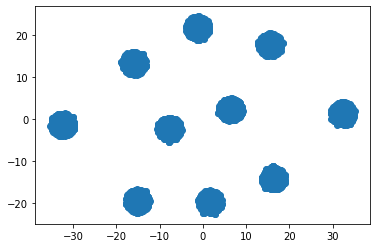

In [86]:
plt.scatter(np.array(tsnedata[:,0]), np.array(tsnedata[:,1]))